# LOESS Trend Analysis

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess  # type: ignore[import-untyped]
from IPython.display import display

from common import RFOOTER
from polling_data_etl import load_polling_data
from previous_election import get_last_election, get_election_result, COALITION, OTHER

LFOOTER = "Australia. Polling data sourced from Wikipedia. "
SHOW_PLOT = True

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/LOESS-trend/")
mg.clear_chart_dir()

## Upload the data

In [3]:
# Load voting intention data
data = load_polling_data("voting_intention")

Using today's voting_intention data file: ../poll-data/voting_intention_next_2025-12-17.csv


### Data Preview

In [4]:
def preview_polling_data(data: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(data.head(10))
    print(data.columns)


# Show the data preview
preview_polling_data(data)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
NaT,Date,Firm,Interview mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-11-30,17 Nov – 14 Dec 2025,Roy Morgan,Online,4862.0,32.000000,26.500000,13.500000,15.500000,NaN,12.500000,55.5,44.5,2025-11-30,False
2025-12-11,8 – 14 Dec 2025,Roy Morgan,Online,1574.0,30.500000,27.500000,13.000000,17.000000,NaN,12.000000,54.5,45.5,2025-12-11,False
2025-12-08,5 – 12 Dec 2025,Redbridge,Online,1012.0,35.000000,26.000000,13.000000,17.000000,NaN,9.000000,56.0,44.0,2025-12-08,False
2025-12-05,3 – 8 Dec 2025,Essential,Online,1300.0,35.789474,27.368421,10.526316,17.894737,NaN,8.421053,52.1,47.9,2025-12-05,False
2025-12-04,2 – 7 Dec 2025,Resolve,Telephone/Online,1800.0,35.000000,26.000000,11.000000,14.000000,8.0,6.000000,55.0,45.0,2025-12-04,False
2025-11-27,17 Nov – 7 Dec 2025,Roy Morgan,Online,3288.0,33.000000,26.000000,13.500000,15.000000,NaN,12.500000,56.0,44.0,2025-11-27,False
2025-11-16,7 – 26 Nov 2025,Redbridge,Online,4775.0,35.000000,26.000000,10.000000,18.000000,NaN,11.000000,54.0,46.0,2025-11-16,False
2025-11-21,19 – 24 Nov 2025,Essential,Online,1020.0,38.250000,28.687500,11.687500,15.937500,NaN,7.437500,53.2,46.8,2025-11-21,True


Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote ALP',
       'Primary vote L/NP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote IND', 'Primary vote OTH', '2PP vote ALP', '2PP vote L/NP',
       'parsed_date', 'problematic'],
      dtype='object')


### Any problematic?

In [5]:
# Check for any problematic entries as identified by the scraper
data.loc[data.problematic]

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
NaT,Date,Firm,Interview mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-11-21,19 – 24 Nov 2025,Essential,Online,1020.0,38.25,28.6875,11.6875,15.9375,NaN,7.4375,53.2,46.8,2025-11-21,True
2025-07-24,18 – 30 Jul 2025,Wolf & Smith,Online,5000.0,36.00,30.0000,NaN,NaN,NaN,NaN,57.0,43.0,2025-07-24,True
NaT,Date,Firm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-11-14,12 – 17 Nov 2025,YouGov (MRP),NaN,3783.0,40.00,30.0000,17.0000,21.0000,16.0,NaN,NaN,NaN,2025-11-14,True


## Establish 2025 Election benchmarks

In [6]:
# Get 2025 election results from shared module
e25 = get_last_election()
print("2025 Election results for annotation:\n", e25)
print(
    "Primary vote check (should be 100%): ",
    e25[COALITION] + e25["ALP"] + e25["GRN"] + e25["ON"] + e25[OTHER],
)

2025 Election results for annotation:
 ALP          34.56
GRN          12.20
ON            6.40
Labor2pp     55.22
Coalition    31.82
Other        15.02
Name: 30, dtype: float64
Primary vote check (should be 100%):  100.0


## LOESS Smoothing

In [7]:
def create_loess_smoothing(data: pd.DataFrame, column: str, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_sorted = data.sort_index().copy()

    # Apply LOESS smoothing
    series = df_sorted[column].dropna()
    dates_as_ordinals = [p.ordinal for p in series.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1
    smoothed = lowess(
        series,
        dates_as_ordinals,
        frac=fraction,  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=series.index)
    smoothed_series.name = f"LOESS {day_span}-day smoothing"
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep="first")]

    return smoothed_series

In [8]:
def plot_scatter_on_ax(
    ax: plt.Axes,
    df: pd.DataFrame,
    col: str,
    color: str,
    symbols: list[str],
    add_labels: bool = True,
) -> None:
    """Plot scatter points for a single series on given axes."""
    for i, brand in enumerate(sorted(df["Brand"].unique())):
        selection = df[df["Brand"] == brand][col]
        if selection.empty or selection.isna().all():
            continue
        # Use ordinals to match mgplot's internal representation
        x = [p.ordinal for p in selection.index]
        ax.scatter(
            x,
            selection.to_numpy(),
            color=color,
            s=20,
            marker=symbols[i % len(symbols)],
            alpha=0.5,
            label=brand if add_labels else None,
        )


def create_chart_with_loess(
    df: pd.DataFrame,
    series: str | list[dict],
    name: str,
    color: str = "",
    f: str = "",
    day_span: int = 90,
) -> None:
    """Create and display the LOESS chart with polling data.

    Args:
        df: DataFrame with polling data
        series: Either a column name (str) for single series, or a list of dicts
                [{"col": "...", "color": "...", "label": "...", "lw": ...}, ...] for multiple series
        name: Chart title
        color: Color for single series mode (ignored if series is a list)
        f: Additional footer text
        day_span: Number of days for LOESS smoothing window
    """
    symbols = list("os^v<>Dx1234+*pHh")

    # -- Normalize single series to list format
    if isinstance(series, str):
        series_list = [{"col": series, "color": color, "label": series, "lw": 2.5}]
    else:
        series_list = series

    # -- Build smoothed data and plot scatter points
    smoothed_df = pd.DataFrame()
    colors = []
    widths = []
    series_cols = []

    # -- plot the individual polls / calculate the smoothed line (for later plotting)
    _fig, ax = plt.subplots()
    for i, s in enumerate(series_list):
        col = s["col"]
        series_cols.append(col)
        # Only add pollster labels for the first series to avoid duplicates
        plot_scatter_on_ax(ax, df, col, s["color"], symbols, add_labels=(i == 0))
        smoothed = create_loess_smoothing(df, col, day_span=day_span)
        smoothed_df[s["label"]] = smoothed
        colors.append(s["color"])
        widths.append(s.get("lw", 2.5))

    # -- Count unique polls where at least one series has data
    total_polls = df[series_cols].notna().any(axis=1).sum()

    # -- Add 2025 election reference line for single series voting charts
    if len(series_list) == 1:
        col = series_list[0]["col"]
        prev_election = get_last_election()
        results_map = {
            "2PP vote ALP": prev_election["Labor2pp"],
            "2PP vote L/NP": 100 - prev_election["Labor2pp"],
            "Primary vote ALP": prev_election["ALP"],
            "Primary vote L/NP": prev_election[COALITION],
            "Primary vote GRN": prev_election["GRN"],
            "Primary vote ONP": prev_election["ON"],
            "Others Primary Vote": prev_election[OTHER],
        }
        if col in results_map:
            result = results_map[col]
            ax.axhline(
                result,
                label=f"2025 Result: {result:.1f}%",
                color=colors[0],
                ls="--",
                lw=1,
            )

    # -- plot the smoothed lines
    mg.line_plot(
        smoothed_df,
        ax=ax,
        color=colors,
        width=widths,
        annotate=True,
    )

    # -- finalise
    mg.finalise_plot(
        ax,
        title=f"{name} - {day_span}-day LOESS Trend",
        xlabel=None,
        ylabel="Percent (%)",
        legend={"loc": "best", "fontsize": "xx-small", "ncol": 3},
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} {f} n={total_polls} polls. ".replace("  ", " "),
        show=SHOW_PLOT,
    )

## Plot LOESS election charts

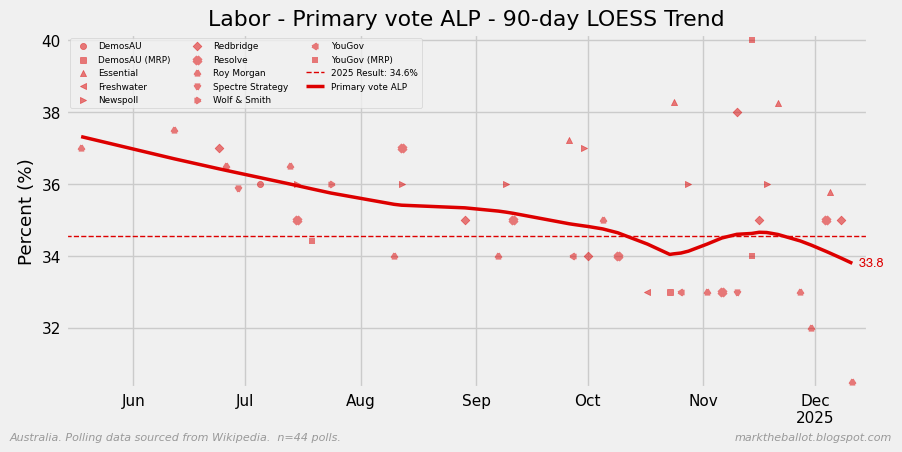

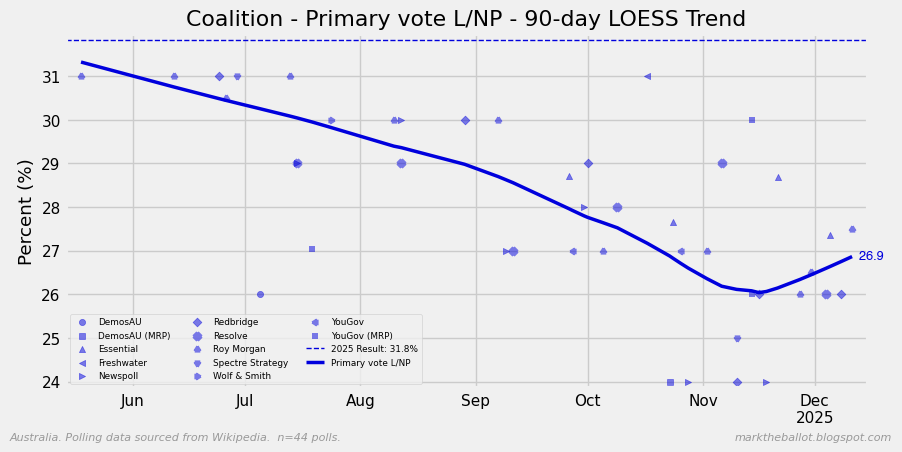

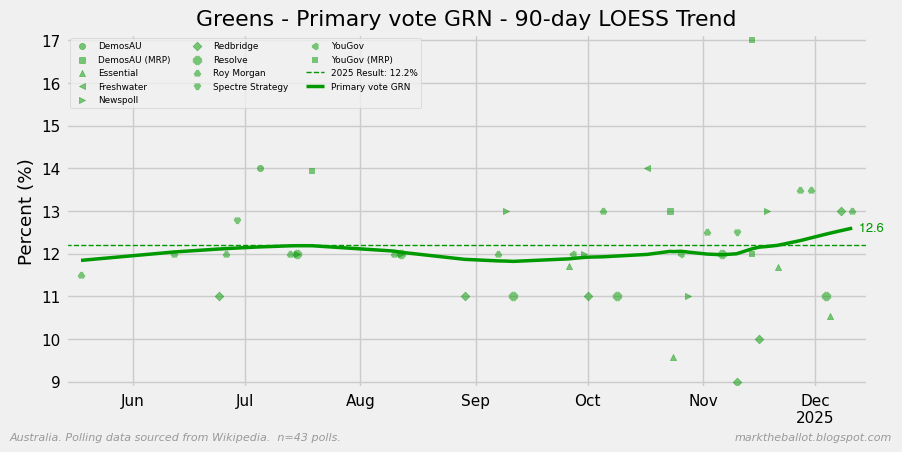

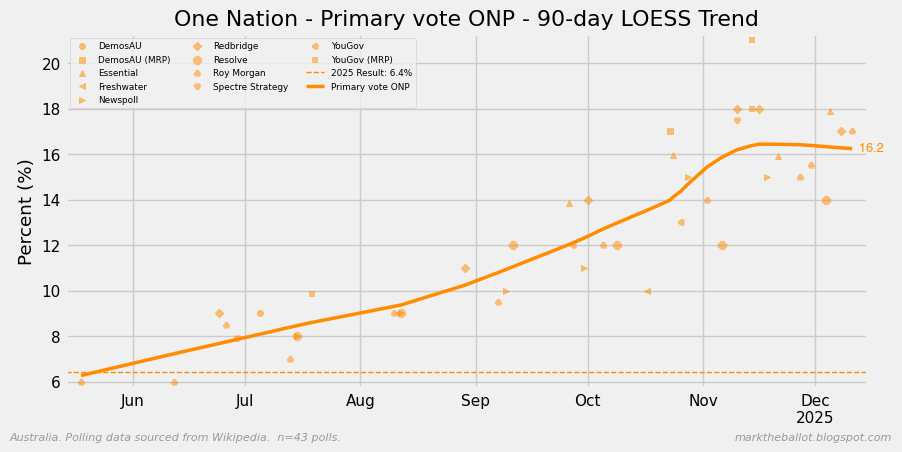

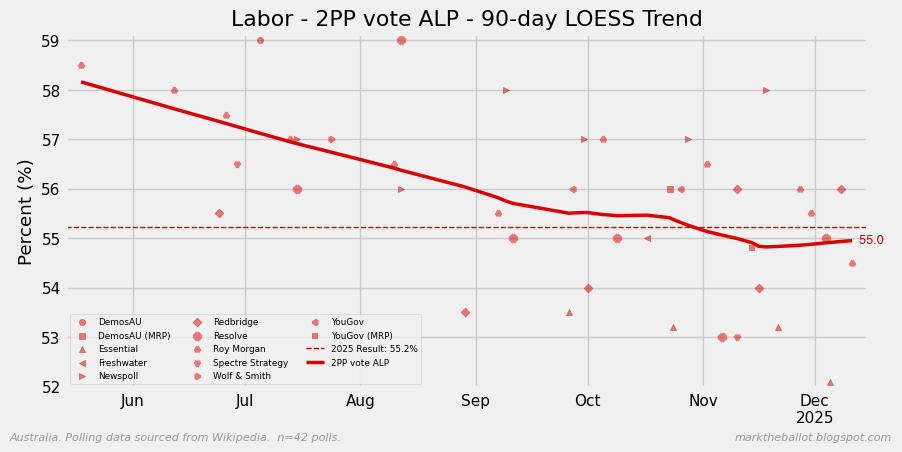

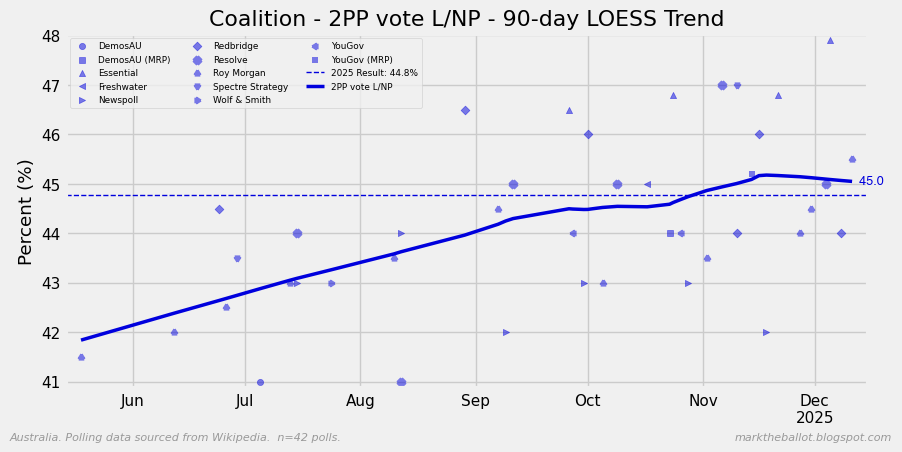

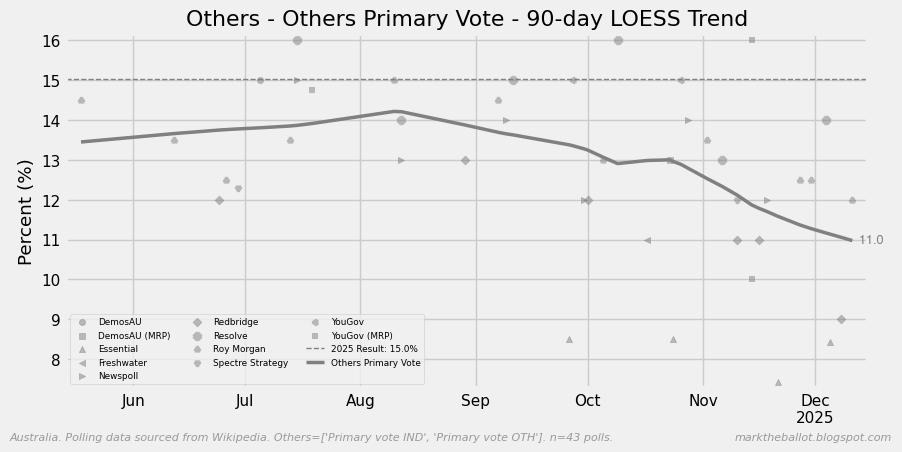

In [9]:
def plot_loess():
    """Plot LOESS trends for specified parties and others."""

    wanted = {
        # party: [name, color]
        "ALP": ["Labor", "#dd0000"],
        "L/NP": ["Coalition", "#0000dd"],
        "GRN": ["Greens", "#009900"],
        "ONP": ["One Nation", "darkorange"],
    }
    used = []
    for col in data.columns:
        if "vote" not in col:
            continue
        for w in wanted:
            if w in col:
                used.append(col)
                name, color = wanted[w]
                create_chart_with_loess(
                    data,
                    series=col,
                    name=f"{name} - {col}",
                    color=color,
                )

    # Create chart for "Others Primary Vote"
    remaining = [w for w in data.columns if w not in used and "vote" in w]
    col = "Others Primary Vote"
    data[col] = data[remaining].sum(axis=1, skipna=True)
    problematic = data[remaining].isna().all(axis=1)
    data.loc[problematic, col] = np.nan  # Ensure problematic rows are NaN
    create_chart_with_loess(
        data,
        series=col,
        name=f"Others - {col}",
        color="grey",
        f=f"Others={remaining}. ",
    )


plot_loess()

## Attitudinal Polling (Preferred PM)

In [10]:
# Load attitudinal (preferred PM) data
attitudinal_data = load_polling_data("preferred_pm")

Using today's preferred_pm data file: ../poll-data/preferred_pm_next_2025-12-17.csv


In [11]:
# Preview attitudinal polling data
if not attitudinal_data.empty:
    display(attitudinal_data.head(10))
    print("Columns:", attitudinal_data.columns.tolist())
else:
    print("No attitudinal polling data available")

,Date,Brand,Sample size,Preferred prime minister Albanese,Preferred prime minister Ley,Preferred prime minister Don't know,Net,Albanese Satisfied,Albanese Dissatisfied,Albanese Don't know,Albanese Net,Ley Satisfied,Ley Dissatisfied,Ley Don't know,Ley Net,parsed_date
parsed_date,,,,,,,,,,,,,,,,
2025-08-12,11 – 14 Aug 2025,Newspoll,1264,51.0,31.0,18.0,20%,49.0,46.0,5.0,3.0,35.0,44.0,21.0,-9.0,2025-08-12
2025-07-15,13 – 18 Jul 2025,Resolve,2311,40.0,25.0,35.0,15%,45.0,42.0,13.0,3.0,38.0,29.0,33.0,9.0,2025-07-15
2025-07-15,14 – 17 Jul 2025,Newspoll,1264,52.0,32.0,16.0,20%,47.0,47.0,6.0,0.0,35.0,42.0,23.0,-7.0,2025-07-15
2025-10-17,15 – 20 Oct 2025,Freshwater,1530,48.0,31.0,22.0,17%,NaN,NaN,NaN,-7.0,NaN,NaN,NaN,-5.0,2025-10-17
2025-11-18,17 – 20 Nov 2025,Newspoll,1245,54.0,27.0,19.0,27%,47.0,47.0,6.0,0.0,26.0,55.0,19.0,-29.0,2025-11-18
2025-07-24,18 – 30 Jul 2025,Wolf & Smith,5000,45.0,35.0,20.0,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-24
2025-11-21,19 – 24 Nov 2025,Essential,1020,NaN,NaN,NaN,NaN,47.0,43.0,10.0,4.0,31.0,44.0,25.0,-19.0,2025-11-21
2025-12-04,2 – 7 Dec 2025,Resolve,1800,41.0,26.0,33.0,15%,48.0,43.0,9.0,5.0,39.0,37.0,24.0,2.0,2025-12-04
2025-05-05,2 – 8 May 2025,Morning Consult,3770,NaN,NaN,NaN,NaN,57.0,33.0,9.0,24.0,NaN,NaN,NaN,NaN,2025-05-05


Columns: ['Date', 'Brand', 'Sample size', 'Preferred prime minister Albanese', 'Preferred prime minister Ley', "Preferred prime minister Don't know", 'Net', 'Albanese Satisfied', 'Albanese Dissatisfied', "Albanese Don't know", 'Albanese Net', 'Ley Satisfied', 'Ley Dissatisfied', "Ley Don't know", 'Ley Net', 'parsed_date']


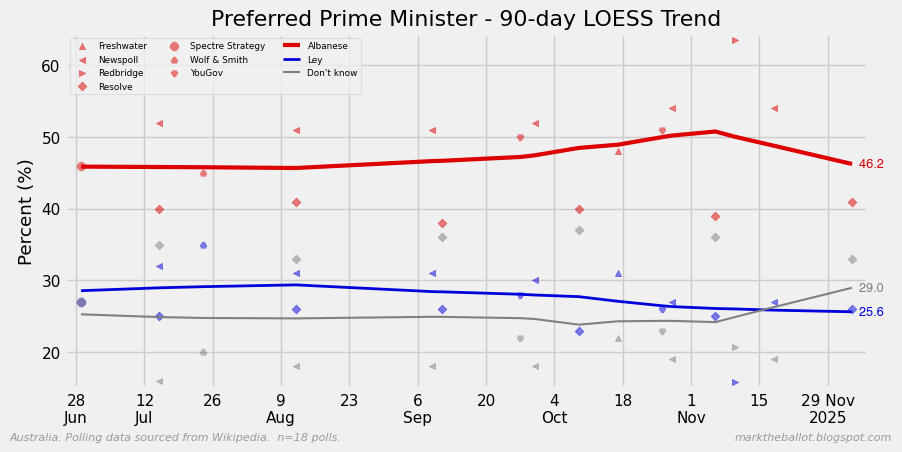

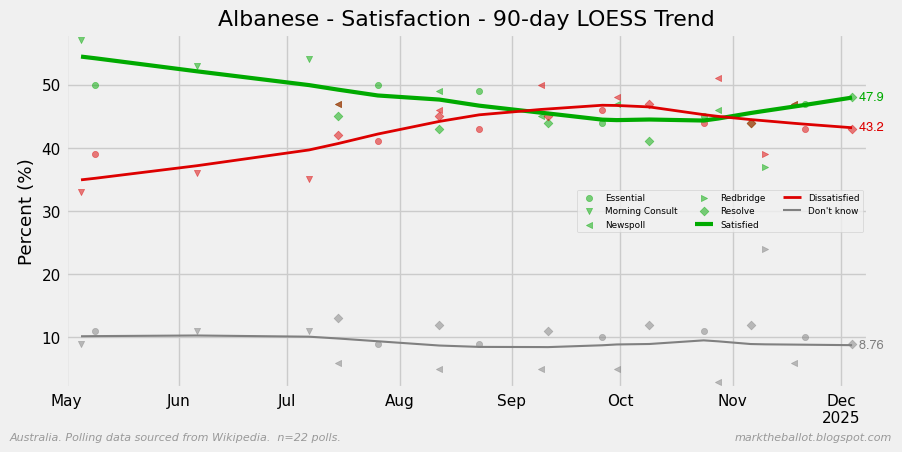

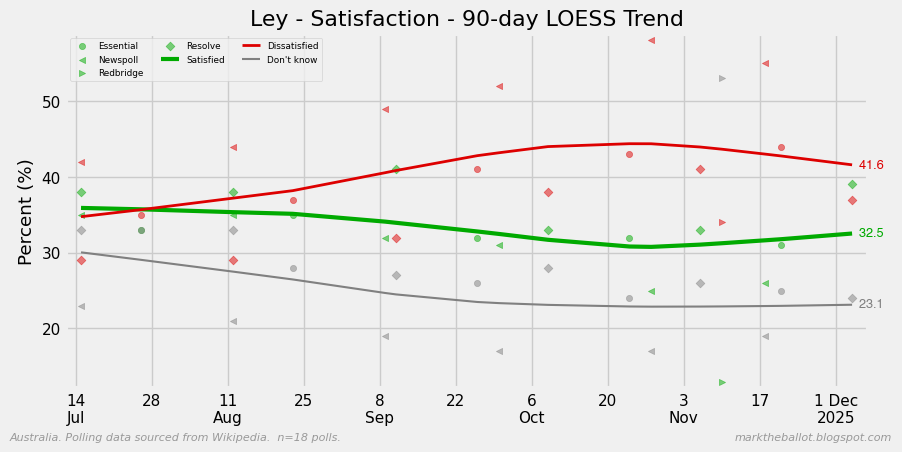

In [12]:
def plot_attitudinal_loess():
    """Plot LOESS trends for attitudinal polling data."""
    if attitudinal_data.empty:
        print("No attitudinal data to plot")
        return

    # Define grouped charts: each is a list of series to plot together
    # Using different linewidths for accessibility
    charts = [
        {
            "name": "Preferred Prime Minister",
            "series": [
                {
                    "col": "Preferred prime minister Albanese",
                    "color": "#dd0000",
                    "label": "Albanese",
                    "lw": 3,
                },
                {
                    "col": "Preferred prime minister Ley",
                    "color": "#0000dd",
                    "label": "Ley",
                    "lw": 2,
                },
                {
                    "col": "Preferred prime minister Don't know",
                    "color": "gray",
                    "label": "Don't know",
                    "lw": 1.5,
                },
            ],
        },
        {
            "name": "Albanese - Satisfaction",
            "series": [
                {
                    "col": "Albanese Satisfied",
                    "color": "#00aa00",
                    "label": "Satisfied",
                    "lw": 3,
                },
                {
                    "col": "Albanese Dissatisfied",
                    "color": "#dd0000",
                    "label": "Dissatisfied",
                    "lw": 2,
                },
                {
                    "col": "Albanese Don't know",
                    "color": "gray",
                    "label": "Don't know",
                    "lw": 1.5,
                },
            ],
        },
        {
            "name": "Ley - Satisfaction",
            "series": [
                {
                    "col": "Ley Satisfied",
                    "color": "#00aa00",
                    "label": "Satisfied",
                    "lw": 3,
                },
                {
                    "col": "Ley Dissatisfied",
                    "color": "#dd0000",
                    "label": "Dissatisfied",
                    "lw": 2,
                },
                {
                    "col": "Ley Don't know",
                    "color": "gray",
                    "label": "Don't know",
                    "lw": 1.5,
                },
            ],
        },
    ]

    for chart in charts:
        # Filter to only include series with columns that exist in the data
        valid_series = [
            s for s in chart["series"] if s["col"] in attitudinal_data.columns
        ]
        if not valid_series:
            print(f"No data for chart: {chart['name']}")
            continue

        try:
            create_chart_with_loess(
                attitudinal_data,
                series=valid_series,
                name=chart["name"],
            )
        except Exception as e:
            print(f"Could not plot {chart['name']}: {e}")


plot_attitudinal_loess()

## Finished

In [13]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-12-17 10:03:46

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

statsmodels: 0.14.6
pandas     : 2.3.3
IPython    : 9.8.0
matplotlib : 3.10.7
numpy      : 2.3.5
pathlib    : 1.0.1
mgplot     : 0.2.14

Watermark: 2.5.0



In [14]:
print("The end.")

The end.
